# ALGORITHME DE TRADING RENTABLE

# Notebook Modelisation

Dans le 1er notebook, nous avons utilisé nos connaissances en finance de marché pour créer des features ayant de réelles valeures prédictibles.

Nous allons maintenant créer un algorithme basé sur XGBoost pour capitaliser sur nos connaissances.

Les datascientists non-initiés à la finance utilisent principalement des algorithmes de régression pour prédire à chaque moment le prochain niveau de prix.

Les traders professionnels ne cherchent pas à prédire les prochains niveaux de prix. Ils recherchent des patterns, des schémas récurrents qui permettent d'obtenir un avantage statistique à certains moments.

Nous allons donc utiliser un algorithme de classification pour acheter ou vendre uniquement lorsque notre modèle à détecter un pattern.

In [2]:
# Importer les librairies

from google.colab import files
import io
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import math
from datetime import timedelta

import seaborn as sns
import missingno as msno 

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import ClusterCentroids
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve, TimeSeriesSplit

from sklearn.metrics import make_scorer, classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve, balanced_accuracy_score

from xgboost import XGBClassifier
from xgboost import XGBRegressor

import time
import shap
import joblib
pd.set_option('display.max_columns', None)

# Importer le df
data_to_load = files.upload()
df = pd.read_csv("EDA_QQQ_5m.csv")

df.head(5)

Saving EDA_QQQ_5m.csv to EDA_QQQ_5m.csv


,Open,High,Low,Close,Volume,close_diff1,close_diff2,close_diff3,close_diff4,close_diff5,veloc_1,veloc_2,veloc_3,veloc_4,veloc_5,body,true_range,body_1,true_range_1,OH,OL,OC,HL,HC,LC,OH_1,OL_1,OC_1,HL_1,HC_1,LC_1,vol_diff1,vol_diff2,vol_diff3,vol_diff4,vol_diff5,sma7_vol,sma20_vol,power,power_1,vol_rev_up,vol_rev_down,sma7,sma20,sma50,sma200,atr,atr_1,bbh,bbb,Donchian_Up_50,Donchian_Down_50,Donchian_Channel_Up,Donchian_Channel_Down,spread_bb_atr,spread_donch_atr,price_sma7,price_sma20,price_sma50,price_sma200,dist_high_sma7,dist_high_sma20,dist_high_sma50,dist_high_sma200,dist_low_sma7,dist_low_sma20,dist_low_sma50,dist_low_sma200,dist_close_bbh,dist_high_bbh,dist_high_bbb,dist_close_bbb,dist_low_bbh,dist_low_bbb,price_donch_low,price_donch_up,sma7_diff1,sma7_diff2,sma7_diff3,sma7_diff4,sma7_diff5,sma20_diff1,sma20_diff2,sma20_diff3,sma20_diff4,sma20_diff5,sma50_diff1,sma50_diff2,sma50_diff3,sma50_diff4,sma50_diff5,bbb_diff1,bbb_diff2,bbb_diff3,bbb_diff4,bbb_diff5,bbh_diff1,bbh_diff2,bbh_diff3,bbh_diff4,bbh_diff5,donch_up_diff1,donch_down_diff1,candle_green,candle_red,doji,consecutive_green_2,consecutive_red_2,consecutive_green_3,consecutive_red_3,consecutive_green_4,consecutive_red_4,consecutive_green_5,consecutive_red_5,spike_vol,absorption_up,absorption_down,reversal_donch_down,reversal_donch_up,reversal_bbb,reversal_bbh,break_donch_down,break_donch_up,break_bbh,break_bbb,trend_up_sma7_20,trend_down_sma7_20,trend_up_sma20_50,trend_down_sma20_50,trend_up_sma50_200,trend_down_sma50_200,trend_up_all_sma,trend_down_all_sma,pente_up_sma7,pente_down_sma7,pente_up_sma20,pente_down_sma20,pente_up_sma50,pente_down_sma50,pente_up_sma200,pente_down_sma200,pente_up_all_sma,pente_down_all_sma,returned_sma7_up,returned_sma7_down,returned_sma20_up,returned_sma20_down,squeeze,returned_bbh,returned_bbb,parallele_up,parallele_down,setup_buy_1,setup_sell_1,setup_buy_2,setup_sell_2,setup_buy_3,setup_sell_3,close_sup_sma_20,close_inf_sma_20,high_sup_sma_20,low_inf_sma_20,high_sup_bbh,low_inf_bbb,close_sup_bbh,close_inf_bbb,double_green,double_red,triple_green,engulfing_up,engulfing_down,Inside_bar,breakup_inside_bar,breakup_double_inside,breakdown_inside_bar,breakdown_double_inside,small_volume,normal_volume,big_volume,xl_volume,small_candle,normal_candle,big_candle,xl_candle,xl_diff1_red,big_diff_red,normal_diff_red,small_diff_red,small_diff_green,normal_diff_green,big_diff_green,xl_diff_green,small_vol_diff_green,normal_vol_diff_green,big_vol_diff_green,xl_vol_diff_green,xl_vol_diff_red,big_vol_diff_red,normal_vol_diff_red,small_vol_diff_red
0,387.940002,388.440002,386.950012,387.060089,2268908.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.879913,1.489990,NaN,NaN,-0.500000,0.989990,0.879913,1.489990,1.379913,-0.110077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.522767e+06,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,387.000000,388.329987,386.769989,387.890015,1287304.0,0.829926,NaN,NaN,NaN,NaN,0.829926,NaN,NaN,NaN,NaN,0.890015,1.559998,-0.879913,1.489990,-1.329987,0.230011,-0.890015,1.559998,0.439972,-1.120026,-0.500000,0.989990,0.879913,1.489990,1.379913,-0.110077,-981604.0,NaN,NaN,NaN,NaN,NaN,NaN,8.251962e+05,1.522767e+06,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [3]:
df.shape

(4678, 200)

In [4]:
df.isna().mean()

Open                   0.0
High                   0.0
Low                    0.0
Close                  0.0
Volume                 0.0
                      ... 
xl_vol_diff_green      0.0
xl_vol_diff_red        0.0
big_vol_diff_red       0.0
normal_vol_diff_red    0.0
small_vol_diff_red     0.0
Length: 200, dtype: float64

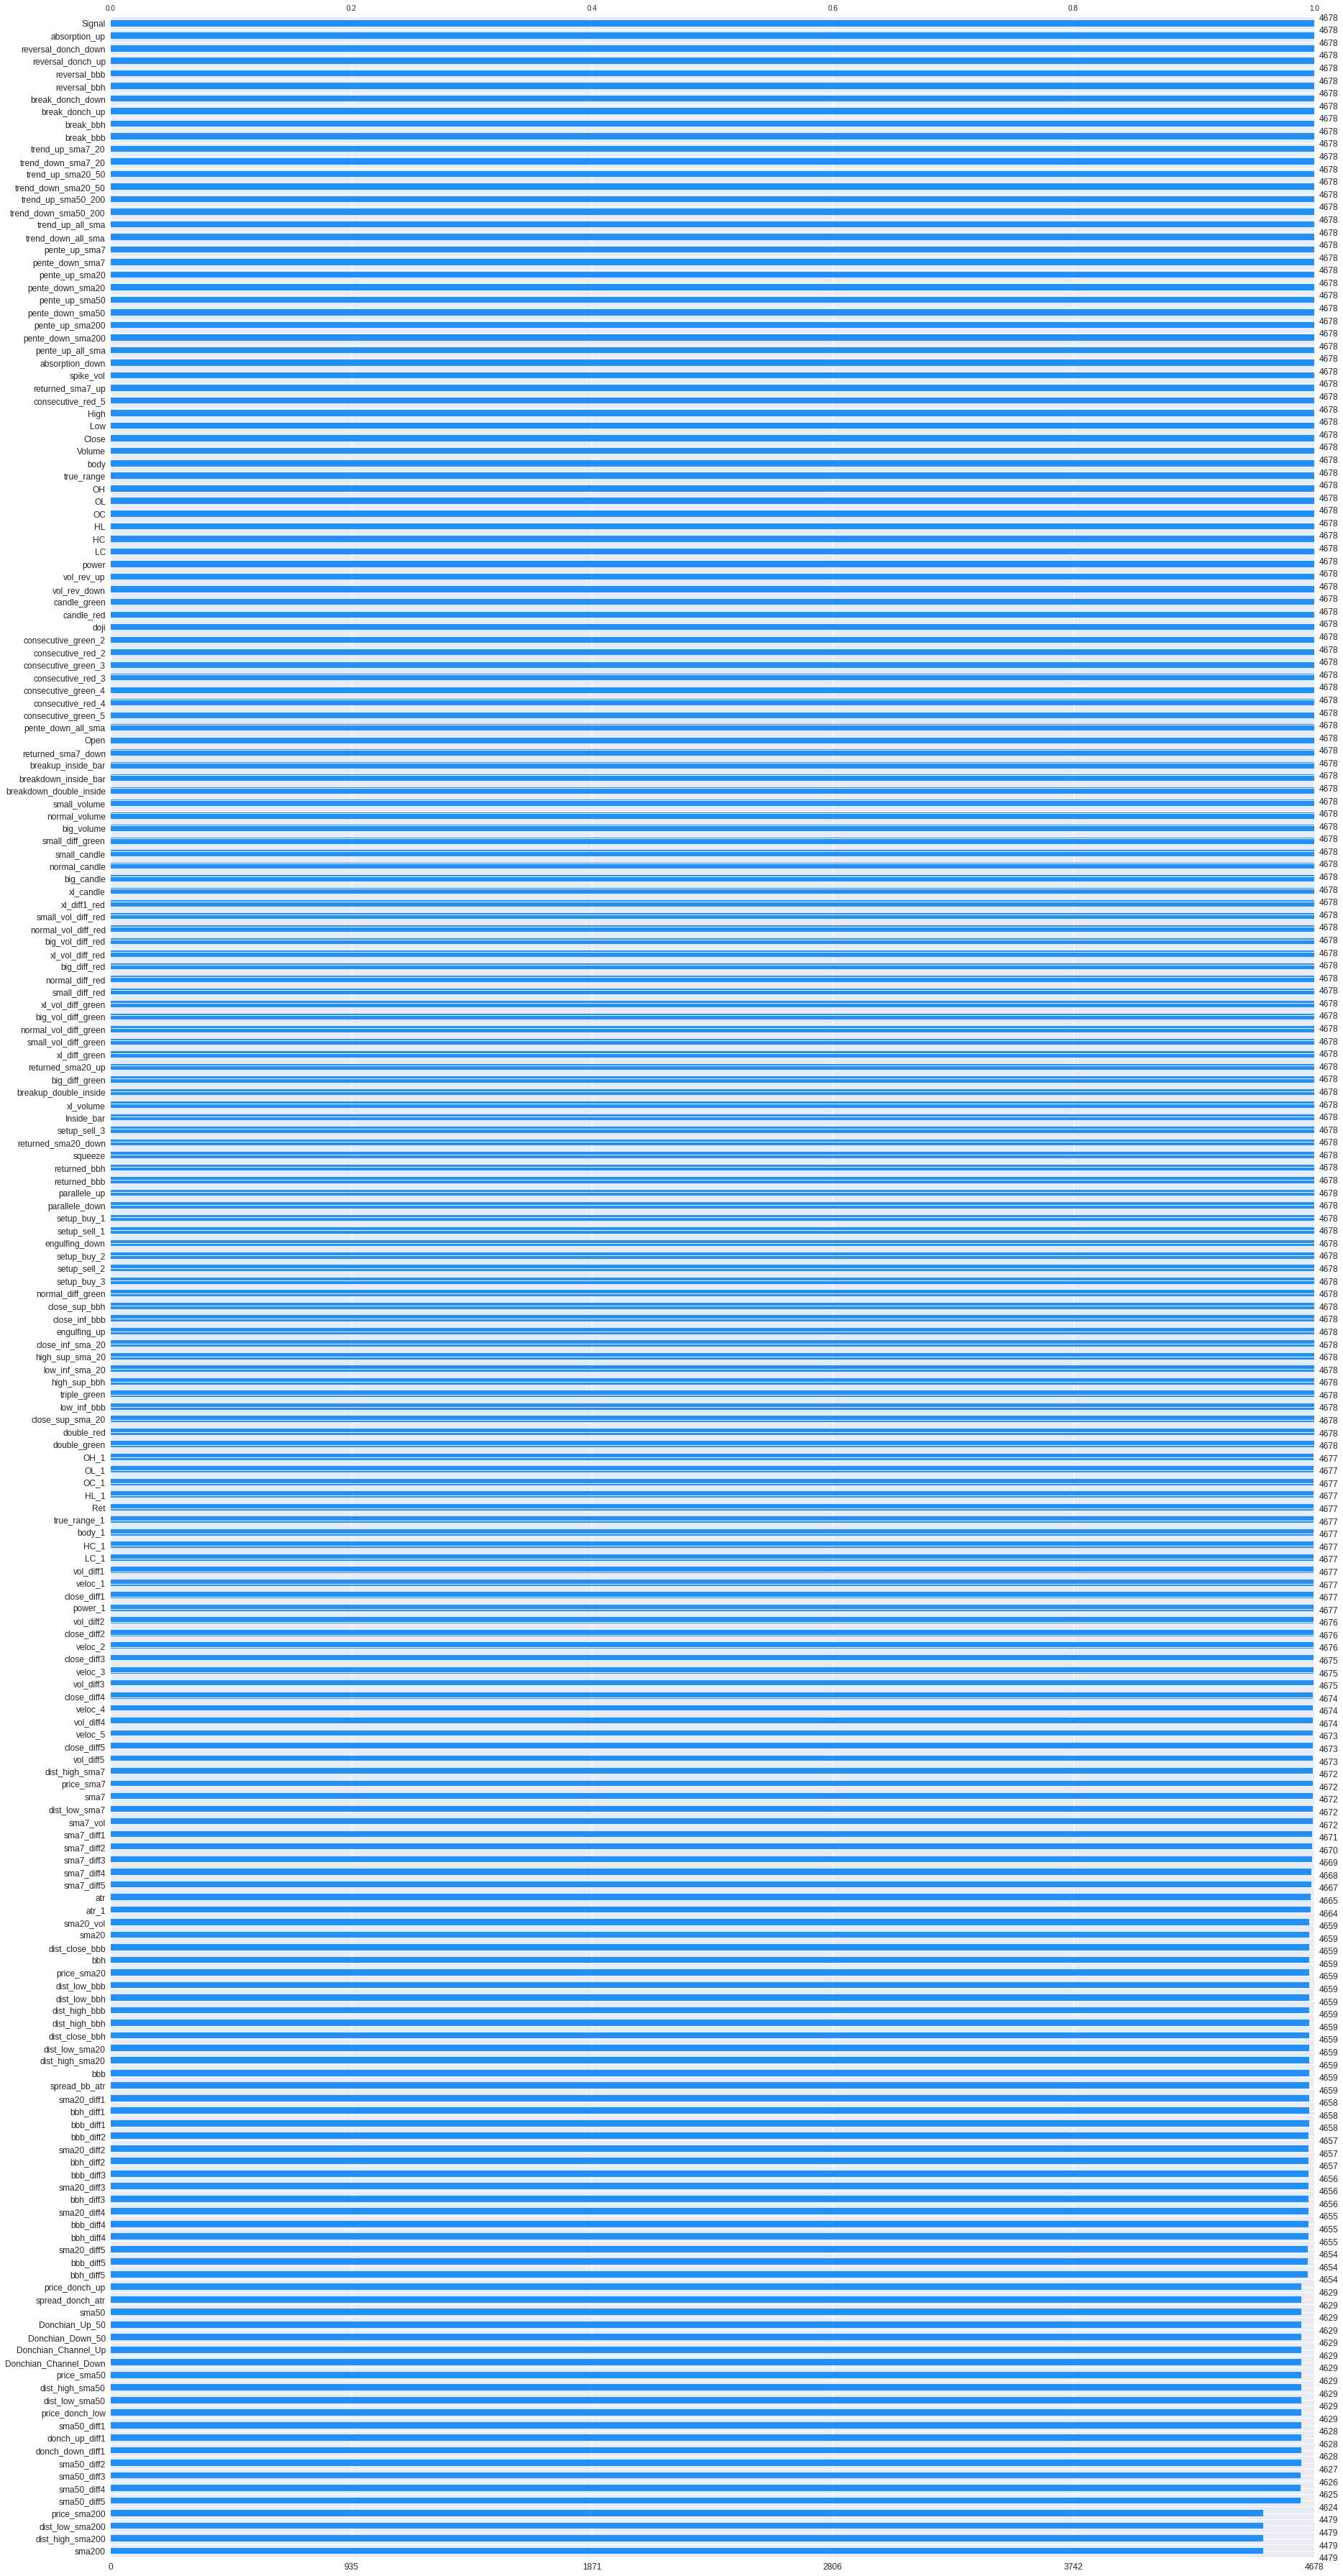

In [19]:
# Visualisation des données manquantes
msno.bar(df, color="dodgerblue", sort="ascending", figsize=(30,65), fontsize=12);

On constate que le dataset a été bien nettoyé et qu'il reste très peu de valeurs manquantes.

## Fonctions

In [47]:
# Drawdown
def drawdown_function(serie):
    cum = serie.dropna().cumsum()+1 # Calcul les rendements cumulés. +1 utilisation des coefficients multiplicateurs
    running_max = np.maximum.accumulate(cum) # Compose les rendements cumulées sur la période
    drawdown = cum/running_max -1 # Compose le drawdown max sur la période
    return drawdown

# Backtest
def backtest(serie, annualiazed_scalar=252):
    benchmark = df['Close'].pct_change(1) # Importer le benchmark
    benchmark.name = "benchmark"
    val = pd.concat((serie, benchmark), axis=1).dropna() # Concatener les rendements du benchmark
    drawdown = drawdown_function(serie) # Compose le drawdown sur la période
    max_drawdown = -np.min(drawdown) #  Compose le drawdown max sur la période
        
    # Affiche le résultat
    fig, (cum, dra) = plt.subplots(1,2, figsize=(20, 6))
    fig.suptitle("Backtest")
    
    # Rendements de la stratégie et du benchmark
    cum.plot(serie.cumsum()*100, color="#39B3C7")
    cum.plot(val["benchmark"].cumsum()*100, color="#B85A0F")
    
    # Legendes et sous titres
    cum.legend(("Strategie", "Benchmark"))
    cum.set_title("Rendement cumulé")
    cum.set_ylabel("Rendement cumulé en %")
    # Ajout du drawdown
    dra.fill_between(drawdown.index,0,drawdown*100, color="#CE5757", alpha=0.65)
    # Titres 
    dra.set_title('Drawdown')
    dra.set_ylabel('Drawdown')
    # Résultat
    plt.show()

# 1. PREPROCESSING

## Définition de la target

Nous utilisons une stratégie qui se base sur les quantiles pour séparer chaque unité temporelle selon son rendement.

Les 20% de rendements les plus élevés et les 20% de rendements les plus faibles seront les cibles à prédire.

Notre modèle va prendre en compte le feature engineering pour identifier des patterns qui permettent de détecter et trader uniquement pendant ces périodes.
Le reste du temps, notre algorithme de trading devra rester hors du marché.

Text(0.5, 1.0, 'Répartition des classes de la target')

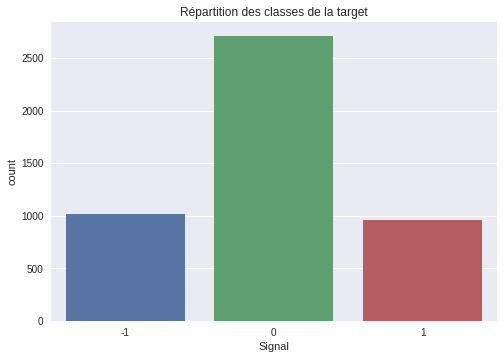

In [21]:
# Calcul de la variation en %
df['Ret'] = (df['Open'].shift(-1)-df['Open'])/df['Open']
return_serie = df['Close'].pct_change(1).dropna()

# Suppression des colonnes qui biaiseraient le résultat
df_final = df.drop(['Open','High', 'Low','Close'], axis=1)

# Créer la colonne 'Signal' et l'initialiser avec 0.
df['Signal'] = 0
t = .7
split = int(t*len(df))

# Attribuez une valeur de 1 et de - 1 à la colonne 'Signal' pour les quantiles avec les rendements les plus élevés et les plus bas.
df.loc[df['Ret'] > df['Ret'][:split].quantile(q=0.80), 'Signal'] = 1
df.loc[df['Ret'] < df['Ret'][:split].quantile(q=0.20), 'Signal'] = -1

# Visualisation de la target
sns.countplot(data = df, x='Signal')
plt.title('Répartition des classes de la target')

## Train test spit

In [6]:
# Determine la target
y = df['Signal'] #-1, 0 et 1

# Suppression des variables inutiles 
X = df.drop(['Signal', 'Ret'], axis=1)

# Découpe le df en train et test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)

# Redimnesionner la target
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

print("Dimension de X_train{} et X_test {}.".format(X_train.shape, X_test.shape))
print("Dimension de y_train {} et y_test {}.".format(y_train.shape, y_test.shape))

Dimension de X_train(935, 200) et X_test (3743, 200).
Dimension de y_train (935, 1) et y_test (3743, 1).


## Imputation

In [27]:
# Imputation avec KnnImputer car les prix d'un actif financier ont plus de probabilité d'être similaire des prix les plus proches 

imputer = KNNImputer(n_neighbors=2, missing_values=np.nan)
X_train_imp = imputer.fit_transform(X_train)
y_train_imp = imputer.fit_transform(y_train)

# Utilisation de .transform et non de fit_transform sur le test setpour éviter le dataleakage
X_test_imp = imputer.fit_transform(X_test)

# 2. MODELISATION

In [24]:
clf1 = XGBClassifier()
pipeline_xgb = Pipeline([('scale', RobustScaler()),
                         ('classifier', clf1)])

# Variables pour les hyperparamètres 
param1 = {'classifier__n_estimators' : [25, 50, 100],
          'classifier__max_depth' : [5, 10, 20]}


In [30]:
gs1 = GridSearchCV(estimator=pipeline_xgb, 
                   param_grid=param1, 
                   cv=5, 
                   n_jobs=-1)

start1 = time.time()
gs1.fit(X_train_imp[], y_train[].ravel())
stop1 = time.time()

vitesse_xgb = stop1-start1
print("Durée de l'optimisation (en sec):", vitesse_xgb)

Durée de l'optimisation (en sec): 34.87224531173706


In [36]:
# Modèle le plus performant et ses hyperparamètres correspondants
print("Modlèle le plus performant :", gs1.best_params_)

# Affichage des métriques
result = pd.DataFrame(gs1.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

Modlèle le plus performant : {'classifier__max_depth': 10, 'classifier__n_estimators': 25}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.787700,0.025887,0.002352,0.000074,10,25,"{'classifier__max_depth': 10, 'classifier__n_e...",0.96,0.96,0.97,0.93,0.95,0.954,0.013565,1
4,1.504491,0.270280,0.002533,0.000045,10,50,"{'classifier__max_depth': 10, 'classifier__n_e...",0.96,0.96,0.97,0.93,0.95,0.954,0.013565,1
6,0.790754,0.030682,0.002335,0.000140,20,25,"{'classifier__max_depth': 20, 'classifier__n_e...",0.96,0.96,0.97,0.93,0.95,0.954,0.013565,1
7,1.371813,0.028405,0.002587,0.000066,20,50,"{'classifier__max_depth': 20, 'classifier__n_e...",0.96,0.96,0.97,0.93,0.95,0.954,0.013565,1
1,1.243028,0.019932,0.002564,0.000026,5,50,"{'classifier__max_depth': 5, 'classifier__n_es...",0.96,0.96,0.97,0.93,0.94,0.952,0.014697,5


X has feature names, but RobustScaler was fitted without feature names


              precision    recall  f1-score   support

          -1       0.95      0.92      0.94       827
           0       0.96      0.97      0.97      2157
           1       0.94      0.96      0.95       759

    accuracy                           0.96      3743
   macro avg       0.95      0.95      0.95      3743
weighted avg       0.96      0.96      0.96      3743



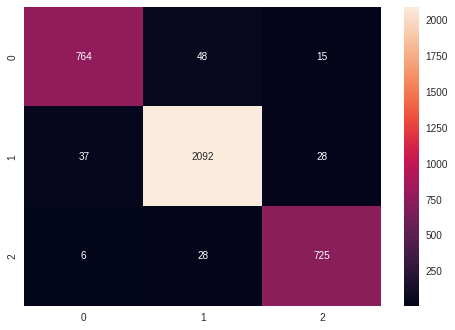

In [56]:
# Prédictions sur le test set
pred_xgb = gs1.predict(X_test)

# Rapport de classification 
cr = classification_report(pred_xgb, y_test)
print(cr)

# Matrice de confusion
cm = confusion_matrix(pred_xgb, y_test)
f = sns.heatmap(cm, annot=True, fmt='d')

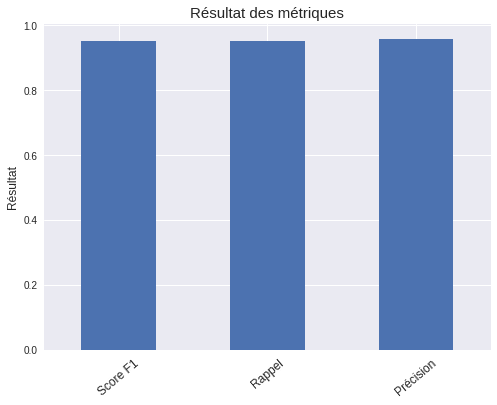

Le score f1 est : 0.9507005638838885
Le rappel est : 0.9518904330249157
La précision est : 0.9567192091904889


In [65]:
# Scores des métriques
score_f1_xgb = f1_score(y_test, pred_xgb, average='macro')
score_recall_xgb = recall_score(y_test, pred_xgb, average='macro')  
score_accuracy_xgb = accuracy_score(y_test, pred_xgb)

# Visualisation des scores
plt.figure(figsize=(8,6))
resultat = pd.Series([score_f1_xgb, score_recall_xgb, score_accuracy_xgb], 
                     index=["Score F1", "Rappel", "Précision"])

resultat.plot.bar()
plt.title("Résultat des métriques", fontsize=15)
plt.ylabel('Résultat', fontsize=12)
degrees = 40
plt.xticks(rotation=degrees, fontsize=12)

plt.show()

print('Le score f1 est :', score_f1_xgb)
print('Le rappel est :', score_recall_xgb)
print('La précision est :', score_accuracy_xgb)

**En observant la matrice de confusion, le report de classification et le score des métriques on constate que le modèle est très performant.**

# 3. BACKTEST

Nous allons désormais appliquer notre modèle sur des signaux de marchés (achat/vente/ne rien faire).

Cela va nous permettre de mettre en perspective le rendement et les risques pris pour obtenir ce rendement.

Nous allons pour cela utiliser 2 métriques clés, le rendement et le drawdwon maximum (perte maximale enregistrée par un portefeuille sur une période donnée). .

In [45]:
# Signal muticlasse (élimine le 0 pour n'ajouter que les achats et les ventes)
Signal_multi = df[df['Signal'] != 0]

# Créer des prédictions pour l'ensemble du dataset
X = np.concatenate((X_train, X_test), axis=0)
df["prediction"] = gs1.predict(X)

# Compose les positions 
df["position"] = np.sign(df["prediction"])

# Compose les rendements 
df["strategy"] = return_serie * df["position"].shift(1)
df["return"] = df["strategy"] 

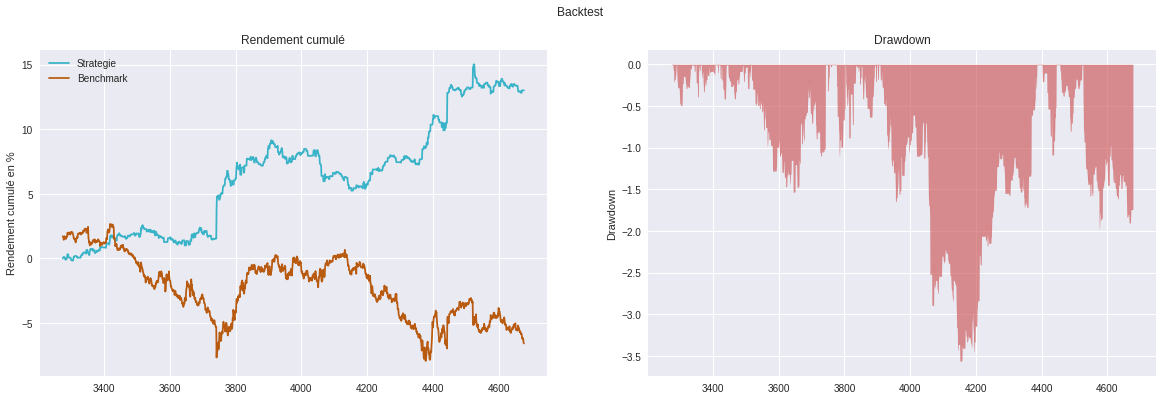

In [48]:
backtest(df["return"].iloc[split:])

**On constate que notre modèle à générer une stratégie très performante.**

**Depuis le 1er janvier, peendant que le Nasdaq perdait 5%, notre stratégie a gagné 15% en 3 mois, soit 200% de superformance sur le benchmark.**

**Il faut également noter que cette performance a été généré avec très peu de risque, notre drawdown maximale étant de 3.5%, soit 4.3 fois moins important que notre rendement.**

# 4. CONCLUSION

Alors qu'il assez simple de performer en bourse lorsque les marchés montent comme lors de la dernière décennie, il est plus difficile de performer lorsque les marchés stagnent ou baissent.

Depuis le début de l'année, les marchés sont très volatils. Comme dit Warren Buffet "Ce n'est que lorsque la marée se retire que vous découvrez qui se baignait sans maillot". Cet environnement est idéal pour mettre en valeur les stratégies réellement performantes qui génèrent un alpha solide.

Nous avons donc utiliser nos compétences en finance de marché pour créer des features ayant de réelles valeures prédictibles.

Nous avons vu que les modèles de régression sont voués à l'échec, les marchés étant efficients la grande majorité du temps.

Nous avons donc créé un modèle basé sur la classification. Notre but était de découvrir, grâce à nos features, les moments où les marchés ne sont pas efficients et détecter les patterns qui génère un avantage statistique.

Notre modèle, basé sur le XGBoost Classifier, a permis de généré une stratégie rentable.
La stratégie à superformée son benchmark de 200%, et le rendement de 15% en 3 mois est 4.3 fois supérieur au drawdown maximum de 3.5%

# 4. ENREGISTREMENT DU MODELE

In [52]:
# Enregistrement du modèle
joblib.dump(pipeline_xgb, 'xgb_qqq_5m.joblib')

['xgb_qqq_5m.joblib']